In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("/Users/santorum/Desktop/scikit-rmt/")

from skrmt.ensemble import WishartEnsemble
from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution
from skrmt.ensemble.utils import get_bins_centers_and_contour

In [174]:
def norm_img_0_255(np_img):
    min_val = np.min(np_img)
    max_val = np.max(np_img)
    return 255 * (np_img - min_val) / (max_val - min_val)

In [4]:
def plot_slices(slices, titles=None, cmap="gray", origin="lower"):
    """Function to display a row of image slices."""
    n_slices = len(slices)

    if titles is None:
        titles = [f"Slice {i+1}" for i in range(n_slices)]

    # Old: fig, axes = plt.subplots(1, n_slices, figsize=(3 * n_slices, 2 * n_slices))
    fig, axes = plt.subplots(1, n_slices, figsize=(3.5 * n_slices, 3.8))

    if len(slices) > 1:
        for i, slice_array in enumerate(slices):
            axes[i].imshow(slice_array, cmap=cmap, origin=origin, aspect="auto")
            axes[i].set_title(titles[i])
    else:
        axes.imshow(slices[0], cmap=cmap, origin=origin)
        axes.set_title(titles[0])

In [5]:
def generate_noisy_imgs(
    original_img: np.ndarray,
    n_snapshots: int,
    sigma: float,
    seed: int,
) -> np.ndarray:
    """Generate `n_snapshots` noisy images of the given original image.

    Args:
        original_img (np.ndarray): 2d numpy array representing the original image
            of size (n_rows, n_cols) = (height, width).
        n_snapshots (int): number of noisy images to generate.
        sigma (float): gaussian standard deviation to corrupt the original image.

    Returns:
        np.ndarray: numpy array of size (n_snapshots, height, width).
    """
    np.random.seed(seed)

    gaussian_noise_mtcs = [np.random.randn(*original_img.shape) for _ in range(n_snapshots)]
    snapshots = [
        original_img + sigma * randn_mtx
        for randn_mtx in gaussian_noise_mtcs
    ]
    return np.stack(snapshots, axis=0)

In [6]:
def denoise_row(X, sigma):
    # M := number of measurements
    # N := number of pixels
    (M, N) = X.shape
    wre = WishartEnsemble(beta=1, p=M, n=N, sigma=sigma)
    wre.matrix = X

    # Principal Component Analysis (PCA) via SVD
    U, S, Vh = np.linalg.svd((1/np.sqrt(N)) * wre.matrix, full_matrices=False)

    # nullifying noisy eigenvalues
    denoised_S = np.where(S <= np.sqrt(wre.lambda_plus), 0, S)

    # reconstructing denoised X
    denoised_X = np.sqrt(N) * np.dot(U * denoised_S, Vh)

    return denoised_X


def denoise_snapshots(snapshots, sigma):
    n_snapshots, img_height, img_width = snapshots.shape
    print(f"Denoising {n_snapshots} snapshots (sigma = {sigma}).")

    denoised_snapshots = np.zeros_like(snapshots)
    for i in range(img_height):  # this can be parallelized
        rows = snapshots[:,i,:]
        denoised_X = denoise_row(X=rows, sigma=sigma)
        denoised_snapshots[:,i,:] = denoised_X
    
    return denoised_snapshots


In [7]:
def plot_mppca(X, sigma):
    wre = WishartEnsemble(beta=1, p=X.shape[0], n=X.shape[1], sigma=sigma)
    wre.matrix = (1/wre.n) * np.matmul(X, X.T)
    eigvals = wre.eigvals()

    # absolute histogram for all eigenvalues
    global_interval = (0.01, eigvals.max())
    wre.plot_eigval_hist(bins=40, interval=global_interval, density=False, normalize=False)

    # histogram for noise-related eigenvalues
    noise_interval = (wre.lambda_minus, wre.lambda_plus)
    wre.plot_eigval_hist(bins=40, interval=noise_interval, density=False, normalize=False)

    # computing normalized histogram
    observed, bin_edges = wre.eigval_hist(
        bins=40, interval=noise_interval, density=True, normalize=False
    )
    centers = np.asarray(get_bins_centers_and_contour(bin_edges))

    mpd = MarchenkoPasturDistribution(ratio=wre.ratio, sigma=sigma)

    height = mpd.pdf(centers)
    width = bin_edges[1]-bin_edges[0]
    # plotting normalized histogram
    plt.bar(bin_edges[:-1], observed, width=width, align='edge')
    # pdf
    plt.plot(centers, height, color='red', linewidth=2)
    plt.show()
    

In [123]:
def compute_snr(ref_img: np.ndarray, test_img: np.ndarray) -> float:
    """
    Computes Signal-to-Noise ratio measured in dB

    Input:
        - ref_img (np.ndarray): 2D numpy array.
        - test_img (np.ndarray): 2D numpy array.
    
    Returns:
        float: signal-to-noise ratio.
    
    Reference:
        - "SNR, PSNR, RMSE, MAE". Daniel Sage at the Biomedical Image Group, EPFL, Switzerland.
            http://bigwww.epfl.ch/sage/soft/snr/
        - D. Sage, M. Unser, "Teaching Image-Processing Programming in Java".
            IEEE Signal Processing Magazine, vol. 20, no. 6, pp. 43-52, November 2003.
            http://bigwww.epfl.ch/publications/sage0303.html
    """
    # checking they are 2D images
    assert len(ref_img.shape) == 2
    # checking both images have the same size
    assert ref_img.shape == test_img.shape

    numerator = np.sum(ref_img**2)
    denominator = np.sum((ref_img - test_img)**2)
    return 10 * np.log10(numerator/denominator)


In [115]:
def compute_psnr(ref_img: np.ndarray, test_img: np.ndarray) -> float:
    """
    Computes Peak Signal-to-Noise ratio measured in dB

    Input:
        - ref_img (np.ndarray): 2D numpy array.
        - test_img (np.ndarray): 2D numpy array.
    
    Returns:
        float: peak signal-to-noise ratio.
    
    Reference:
        - https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
    """
    # checking they are 2D images
    assert len(ref_img.shape) == 2
    # checking both images have the same size
    assert ref_img.shape == test_img.shape

    mse = 1/(np.prod(ref_img.shape)) * np.sum((ref_img - test_img)**2)
    return 20 * np.log10(255.0 / np.sqrt(mse))


In [100]:
tumor_slice = np.load("sim_data/sample_tumor_img.npy")
tumor_slice.shape

(184, 132)

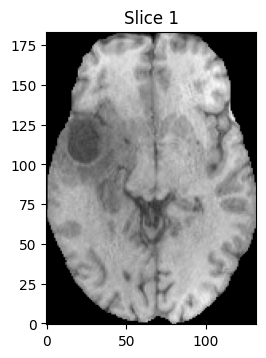

In [11]:
plot_slices([tumor_slice])

In [12]:
tumor_slice.min(), tumor_slice.max()

(0.0, 255.0)

In [13]:
sigma = 100
snapshots = generate_noisy_imgs(tumor_slice, n_snapshots=100, sigma=sigma, seed=1)

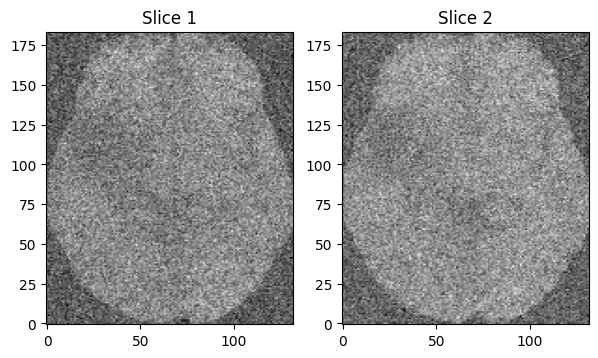

In [14]:
plot_slices([snapshots[0], snapshots[1]])

In [15]:
denoised_snapshots = denoise_snapshots(snapshots=snapshots, sigma=sigma)

Denoising 100 snapshots (sigma = 100).


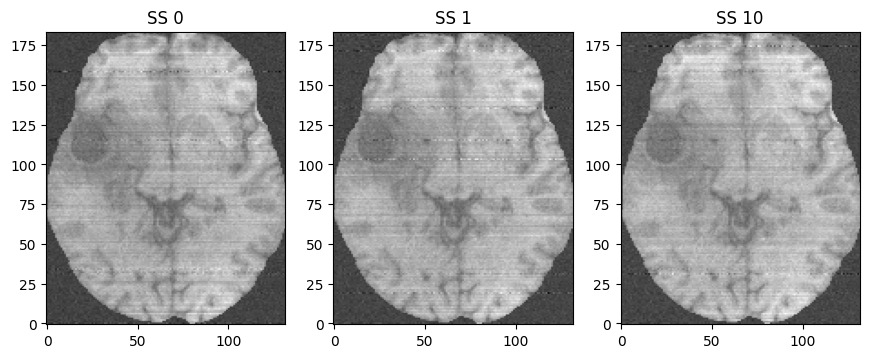

In [16]:
plot_slices([denoised_snapshots[0], denoised_snapshots[1], denoised_snapshots[10]], titles=["SS 0", "SS 1", "SS 10"])

(100, 132)


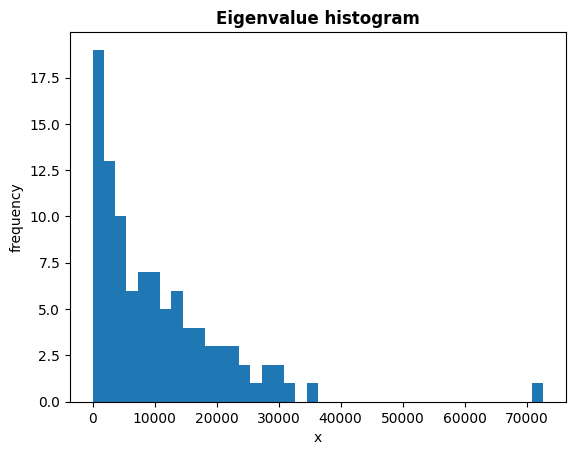

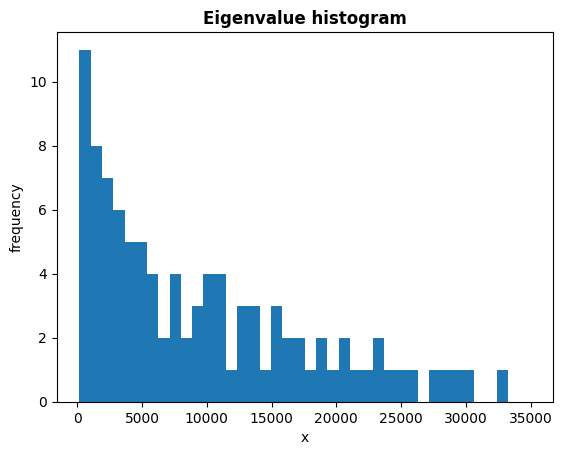

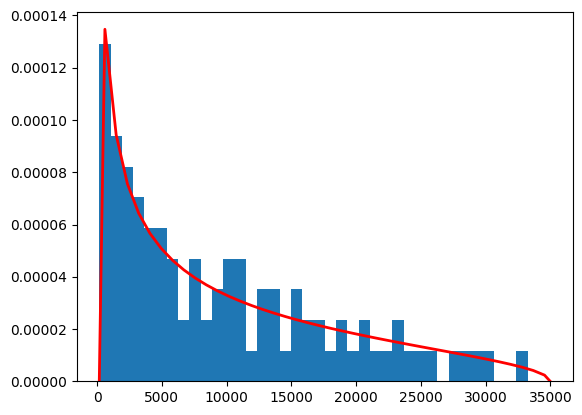

In [17]:
X = snapshots[:,0,:]
print(X.shape)
plot_mppca(snapshots[:,0,:], sigma=sigma)

## 1.0 Moving the brain around

In [101]:
tumor_slice = np.load("sim_data/sample_tumor_img.npy")
tumor_slice.shape

(184, 132)

In [102]:
pad_tumor_slice = np.pad(tumor_slice, pad_width=5, mode="constant", constant_values=0)
pad_tumor_slice.shape

(194, 142)

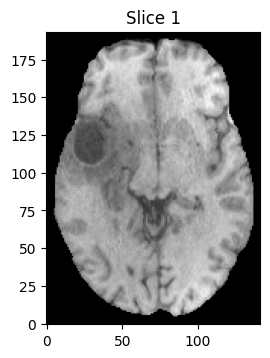

In [103]:
plot_slices([pad_tumor_slice])

In [104]:
pad_tumor_slice[:,2:-2].shape

(194, 138)

(194, 142)


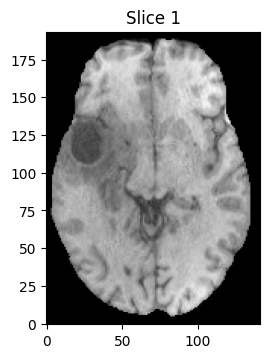

In [105]:
moved_to_left = np.zeros(pad_tumor_slice.shape)
moved_to_left = np.hstack((pad_tumor_slice[:,2:-2], moved_to_left[:,-4:]))
print(moved_to_left.shape)

plot_slices([moved_to_left])

(194, 142)


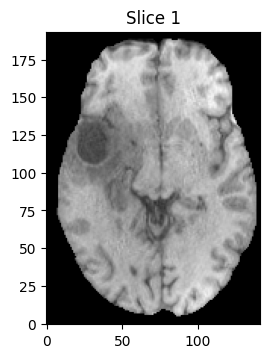

In [106]:
moved_to_right = np.zeros(pad_tumor_slice.shape)
moved_to_right = np.hstack((moved_to_right[:,:4], pad_tumor_slice[:,2:-2]))
print(moved_to_right.shape)

plot_slices([moved_to_right])

In [124]:
def generate_moved_noisy_imgs(
    original_img: np.ndarray,
    n_snapshots: int,
    sigma: float,
    seed: int,
) -> np.ndarray:
    np.random.seed(seed)

    snapshots = []
    for _ in range(n_snapshots):
        ss = np.copy(original_img)
        moved_ss = np.zeros(ss.shape)
        n_pixels_to_move = np.random.choice([0, 1, 2, 3], size=1)[0]
        if n_pixels_to_move == 0:
            moved_ss = ss
        else:
            move_left_or_right = np.random.choice(["left", "right"], size=1)[0]
            if move_left_or_right == "left":
                moved_ss = np.hstack((ss[:,n_pixels_to_move:-n_pixels_to_move], moved_ss[:,-(2*n_pixels_to_move):]))
            elif move_left_or_right == "right":
                moved_ss = np.hstack((moved_ss[:,:(2*n_pixels_to_move)], ss[:,n_pixels_to_move:-n_pixels_to_move]))
            else:
                raise ValueError(f"Invalid value returned by random choice: {move_left_or_right}.")

        moved_noisy_ss = moved_ss + sigma * np.random.randn(*moved_ss.shape)
        snapshots.append(moved_noisy_ss)

    return np.stack(snapshots, axis=0)

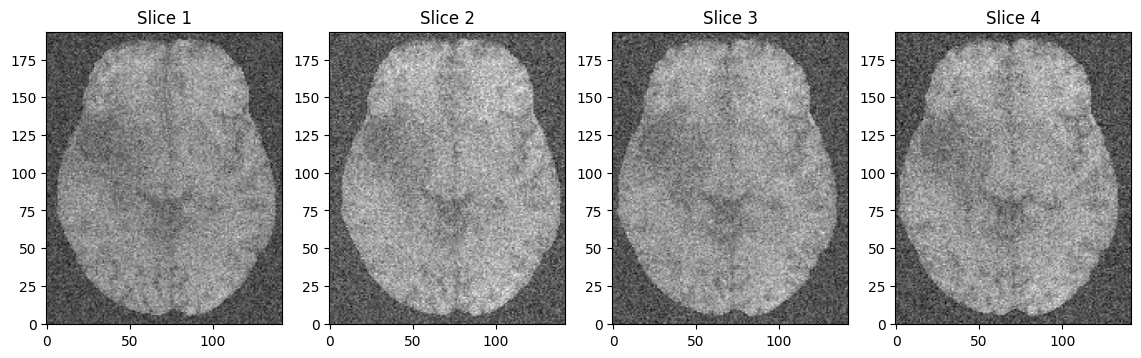

In [125]:
mn_ss = generate_moved_noisy_imgs(original_img=pad_tumor_slice, n_snapshots=4, sigma=50, seed=1)

plot_slices(mn_ss)

In [191]:
sigma = 40 # 10, 30, 60
snapshots = generate_moved_noisy_imgs(original_img=pad_tumor_slice, n_snapshots=100, sigma=sigma, seed=1)

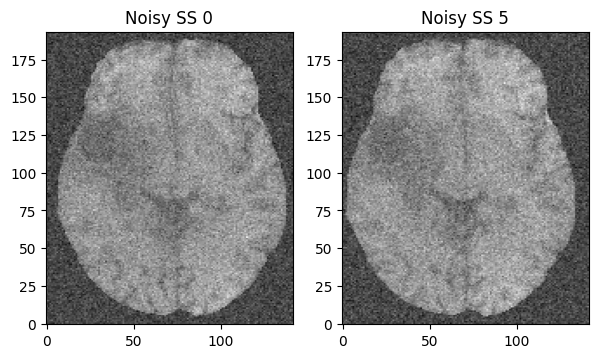

In [192]:
plot_slices([snapshots[0], snapshots[5]], titles=["Noisy SS 0", "Noisy SS 5"])

In [193]:
denoised_snapshots = denoise_snapshots(snapshots=snapshots, sigma=sigma)

Denoising 100 snapshots (sigma = 40).


In [194]:
norm_denoised_snapshots = []
for den_ss in denoised_snapshots:
    norm_denoised_snapshots.append(norm_img_0_255(den_ss))
norm_denoised_snapshots = np.asarray(norm_denoised_snapshots)
norm_denoised_snapshots.shape

(100, 194, 142)

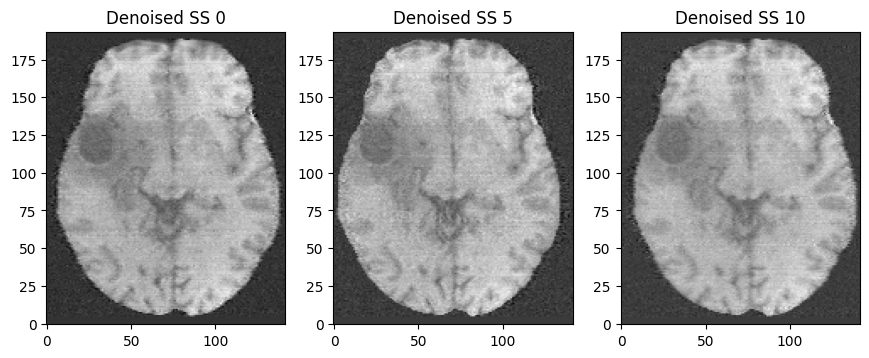

In [195]:
plot_slices([denoised_snapshots[0], denoised_snapshots[5], denoised_snapshots[10]],
            titles=["Denoised SS 0", "Denoised SS 5", "Denoised SS 10"])

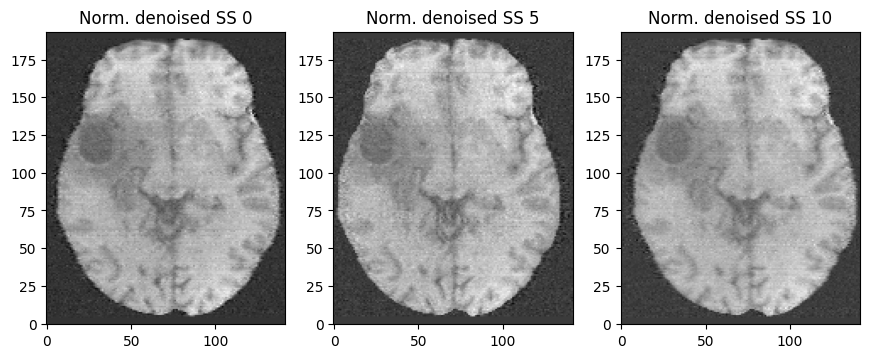

In [196]:
plot_slices([norm_denoised_snapshots[0], norm_denoised_snapshots[5], norm_denoised_snapshots[10]],
            titles=["Norm. denoised SS 0", "Norm. denoised SS 5", "Norm. denoised SS 10"])

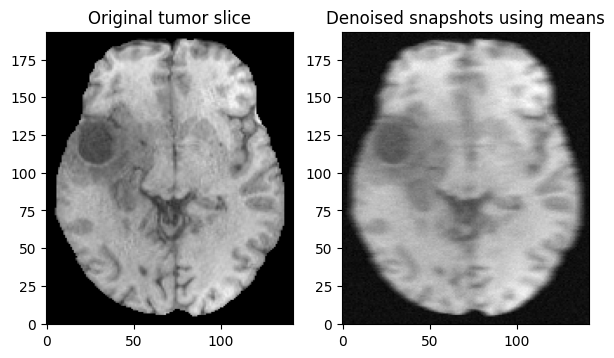

In [197]:
means_denoised_slice = np.mean(snapshots, axis=0)
plot_slices([pad_tumor_slice, means_denoised_slice],
            titles=["Original tumor slice", "Denoised snapshots using means"])

In [198]:
mppca_snr_0 = compute_snr(ref_img=pad_tumor_slice, test_img=denoised_snapshots[0])
mppca_norm_snr_0 = compute_snr(ref_img=pad_tumor_slice, test_img=norm_denoised_snapshots[0])
means_snr = compute_snr(ref_img=pad_tumor_slice, test_img=means_denoised_slice)

print(f"SNR for denoised snapshot id=0: {mppca_snr_0}")
print(f"SNR for normalized denoised snapshot id=0: {mppca_norm_snr_0}")
print(f"SNR for denoised img using means: {means_snr}")

SNR for denoised snapshot id=0: 16.295919269765985
SNR for normalized denoised snapshot id=0: 11.629208002244933
SNR for denoised img using means: 19.72610165437034


In [199]:
mppca_psnr_0 = compute_psnr(ref_img=pad_tumor_slice, test_img=denoised_snapshots[0])
mppca_norm_psnr_0 = compute_psnr(ref_img=pad_tumor_slice, test_img=norm_denoised_snapshots[0])
means_psnr = compute_psnr(ref_img=pad_tumor_slice, test_img=means_denoised_slice)

print(f"Peak SNR for denoised snapshot id=0: {mppca_psnr_0}")
print(f"Peak SNR for normalized denoised snapshot id=0: {mppca_norm_psnr_0}")
print(f"Peak SNR for denoised img using means: {means_psnr}")

Peak SNR for denoised snapshot id=0: 21.933856010395985
Peak SNR for normalized denoised snapshot id=0: 17.267144742874933
Peak SNR for denoised img using means: 25.36403839500034


In [200]:
denoised_snapshots[0].min(), denoised_snapshots.max()

(-70.83870253131913, 345.4052025626691)

In [201]:
norm_denoised_snapshots[0].min(), norm_denoised_snapshots.max()

(0.0, 255.00000000000003)

In [202]:
means_denoised_slice.min(), means_denoised_slice.max()

(-15.790156039998081, 243.5854142902241)

In [203]:
pad_tumor_slice.min(), pad_tumor_slice.max()

(0.0, 255.0)

## 2.0 Using Rician noise to corrupt the images

In [31]:
from scipy.stats import rice

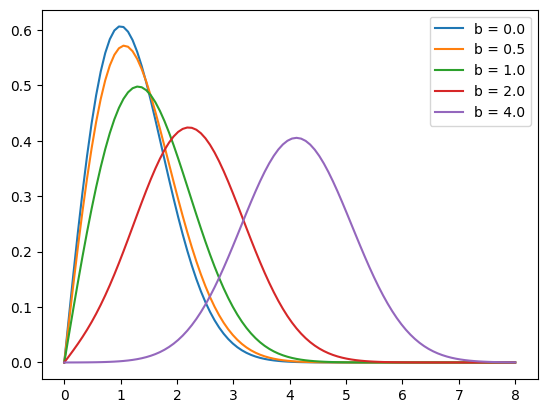

In [32]:
xx = np.linspace(0, 8, 100)

for b in [0., 0.5, 1.0, 2.0, 4.0]:
    pdf_values = rice.pdf(x=xx, b=b, scale=1)
    plt.plot(xx, pdf_values, label=f"b = {b}")
plt.legend()
plt.show()

In [33]:
n_rician_samples = tumor_slice.shape[0] * tumor_slice.shape[1]

rician_samples = rice.rvs(b=2, scale=60, size=n_rician_samples)

rice_tumor_slice = tumor_slice + rician_samples.reshape(tumor_slice.shape)
rice_tumor_slice.shape

(184, 132)

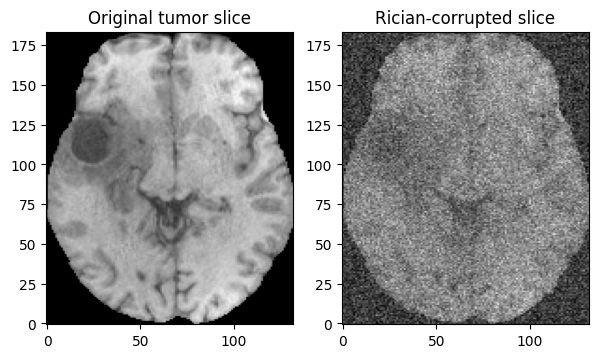

In [34]:
plot_slices([tumor_slice, rice_tumor_slice], titles=["Original tumor slice", "Rician-corrupted slice"])

In [35]:
def generate_rician_noisy_imgs(
    original_img: np.ndarray,
    n_snapshots: int,
    rice_b: float,
    sigma: float,
    seed: int,
):
    np.random.seed(seed)

    n_rician_samples = n_snapshots * np.prod(original_img.shape)
    rician_samples = rice.rvs(b=rice_b, scale=sigma, size=n_rician_samples)
    rician_noise_mtcs = np.reshape(rician_samples, (n_snapshots, *(original_img.shape)))

    noisy_imgs = [tumor_slice + rician_mtx for rician_mtx in rician_noise_mtcs]
    return np.stack(noisy_imgs, axis=0)



In [36]:
sigma = 80
snapshots = generate_rician_noisy_imgs(
    original_img=tumor_slice,
    n_snapshots=100,
    rice_b=10,
    sigma=sigma,
    seed=1
)

snapshots.shape

(100, 184, 132)

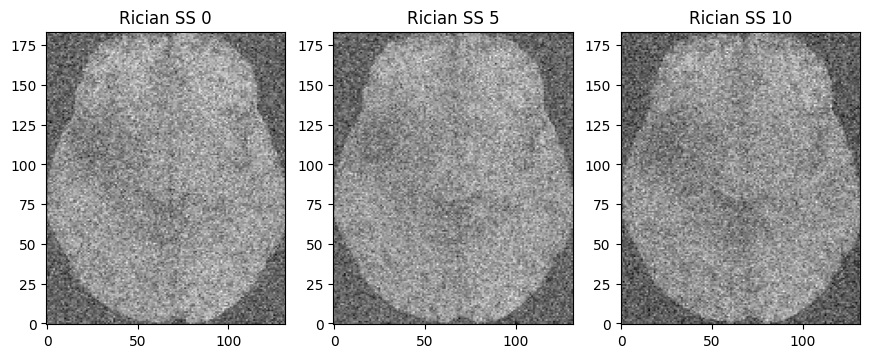

In [37]:
plot_slices([snapshots[0], snapshots[5], snapshots[10]], titles=["Rician SS 0", "Rician SS 5", "Rician SS 10"])

In [38]:
denoised_snapshots = denoise_snapshots(snapshots, sigma=sigma)

Denoising 100 snapshots (sigma = 80).


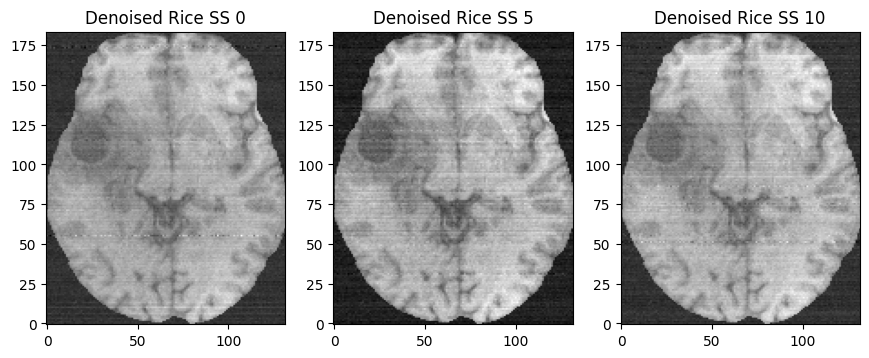

In [39]:
plot_slices([denoised_snapshots[0], denoised_snapshots[5], denoised_snapshots[10]],
            titles=["Denoised Rice SS 0", "Denoised Rice SS 5", "Denoised Rice SS 10"])

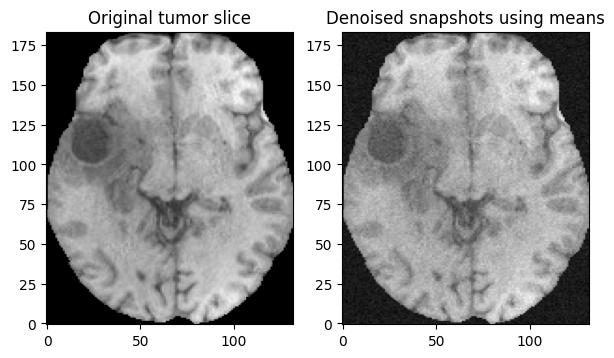

In [40]:
plot_slices([tumor_slice, np.mean(snapshots, axis=0)],
            titles=["Original tumor slice", "Denoised snapshots using means"])

## 3.0 Adding "complex" rician noise

Reference: https://github.com/dipy/dipy/blob/master/dipy/sims/voxel.py#L75

In [41]:
def generate_complex_rician_noisy_imgs(
    original_img: np.ndarray,
    n_snapshots: int,
    sigma: float,
    seed: int,
):
    # https://github.com/dipy/dipy/blob/master/dipy/sims/voxel.py#L75
    np.random.seed(seed)

    noisy_imgs = []
    for _ in range(n_snapshots):
        noise1 = np.random.normal(0, sigma, size=original_img.shape)
        noise2 = np.random.normal(0, sigma, size=original_img.shape) 

        # https://github.com/dipy/dipy/blob/master/dipy/sims/voxel.py#L56
        noisy_img_sample = np.sqrt((original_img + noise1) ** 2 + noise2 ** 2)
        noisy_imgs.append(noisy_img_sample)

    return np.stack(noisy_imgs, axis=0)



In [42]:
sigma = 60
snapshots = generate_complex_rician_noisy_imgs(
    original_img=tumor_slice,
    n_snapshots=100,
    # rice_b=10,
    sigma=sigma,
    seed=1
)

snapshots.shape

(100, 184, 132)

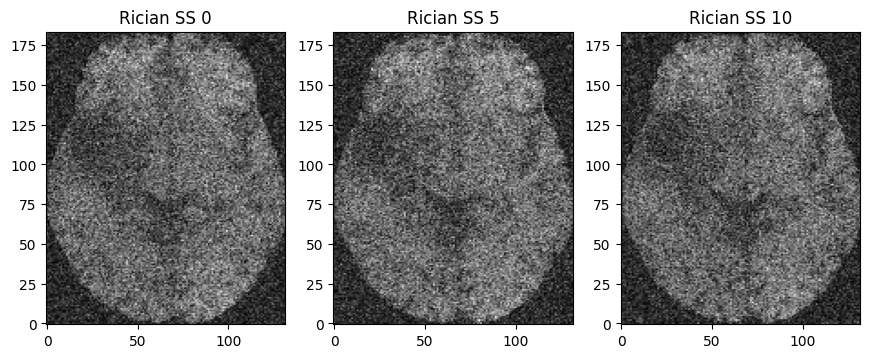

In [43]:
plot_slices([snapshots[0], snapshots[5], snapshots[10]], titles=["Rician SS 0", "Rician SS 5", "Rician SS 10"])

In [44]:
denoised_snapshots = denoise_snapshots(snapshots, sigma=sigma)

Denoising 100 snapshots (sigma = 60).


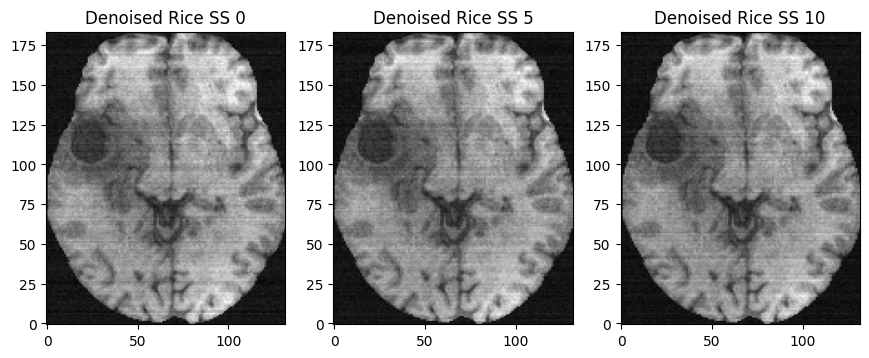

In [45]:
plot_slices([denoised_snapshots[0], denoised_snapshots[5], denoised_snapshots[10]],
            titles=["Denoised Rice SS 0", "Denoised Rice SS 5", "Denoised Rice SS 10"])

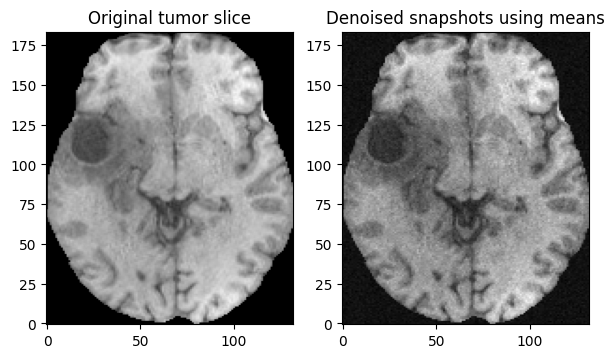

In [46]:
plot_slices([tumor_slice, np.mean(snapshots, axis=0)],
            titles=["Original tumor slice", "Denoised snapshots using means"])

## 4.0 Adding Rician noise and randomly missing some values

In [47]:
def pixel_dropout(snapshots: np.ndarray, seed: int, dropout_prob: float = 0.1):
    np.random.seed(seed)

    dropout_mtx = np.random.choice(
        a=[0,1], size=snapshots.shape, p=[dropout_prob, 1-dropout_prob]
    )

    return snapshots * dropout_mtx

In [48]:
sigma = 80

dropout_tumor_slice = pixel_dropout(tumor_slice, dropout_prob=0.05, seed=1)

dropout_snapshots = generate_rician_noisy_imgs(
    original_img=dropout_tumor_slice,
    n_snapshots=100,
    rice_b=10,
    sigma=sigma,
    seed=1
)

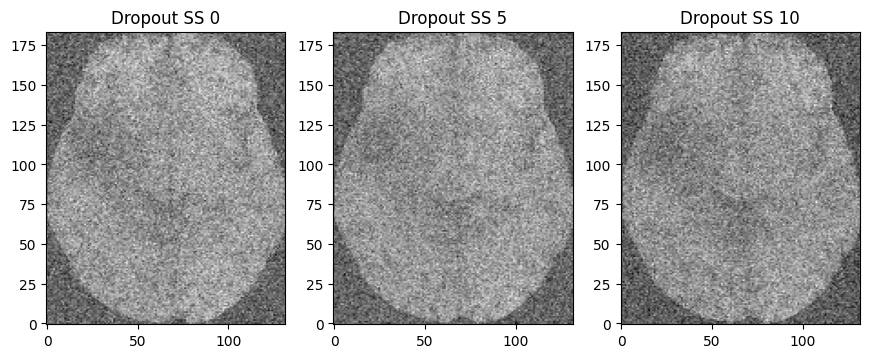

In [49]:
plot_slices([dropout_snapshots[0], dropout_snapshots[5], dropout_snapshots[10]],
            titles=["Dropout SS 0", "Dropout SS 5", "Dropout SS 10"])

In [50]:
denoised_snapshots = denoise_snapshots(dropout_snapshots, sigma=sigma)

Denoising 100 snapshots (sigma = 80).


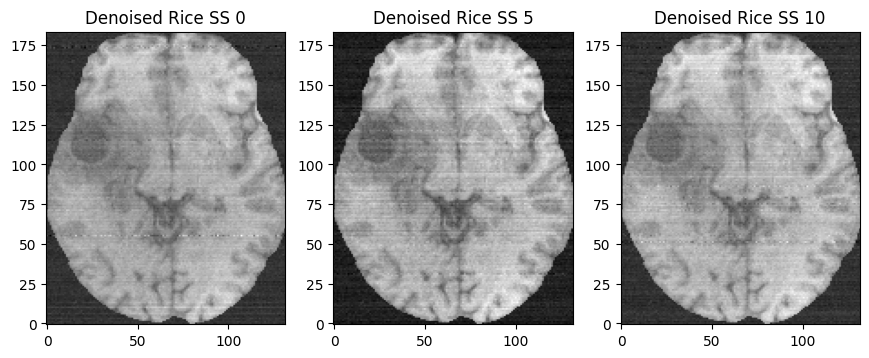

In [51]:
plot_slices([denoised_snapshots[0], denoised_snapshots[5], denoised_snapshots[10]],
            titles=["Denoised Rice SS 0", "Denoised Rice SS 5", "Denoised Rice SS 10"])

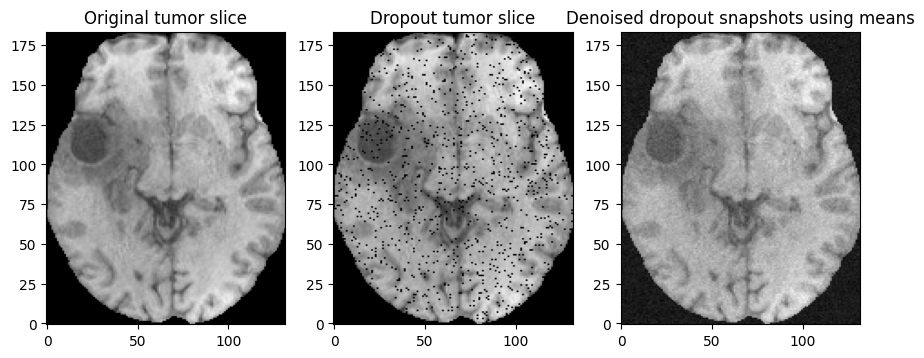

In [52]:
plot_slices([tumor_slice, dropout_tumor_slice, np.mean(dropout_snapshots, axis=0)],
            titles=["Original tumor slice", "Dropout tumor slice", "Denoised dropout snapshots using means"])

## 5.0 Adding Rician noise + displacement

In [214]:
def generate_rician_noisy_moved_imgs(
    original_img: np.ndarray,
    n_snapshots: int,
    sigma: float,
    rice_b: float,
    seed: int,
) -> np.ndarray:
    np.random.seed(seed)

    snapshots = []
    for _ in range(n_snapshots):
        ss = np.copy(original_img)
        moved_ss = np.zeros(ss.shape)
        n_pixels_to_move = np.random.choice([0, 1, 2, 3], size=1)[0]
        if n_pixels_to_move == 0:
            moved_ss = ss
        else:
            move_left_or_right = np.random.choice(["left", "right"], size=1)[0]
            if move_left_or_right == "left":
                moved_ss = np.hstack((ss[:,n_pixels_to_move:-n_pixels_to_move], moved_ss[:,-(2*n_pixels_to_move):]))
            elif move_left_or_right == "right":
                moved_ss = np.hstack((moved_ss[:,:(2*n_pixels_to_move)], ss[:,n_pixels_to_move:-n_pixels_to_move]))
            else:
                raise ValueError(f"Invalid value returned by random choice: {move_left_or_right}.")

        n_rician_samples = np.prod(original_img.shape)
        rician_samples = rice.rvs(b=rice_b, scale=sigma, size=n_rician_samples)
        rician_noise_mtx = np.reshape(rician_samples, original_img.shape)
        rician_moved_noisy_ss = moved_ss + rician_noise_mtx
        snapshots.append(rician_moved_noisy_ss)

    return np.stack(snapshots, axis=0)

In [225]:
sigma = 50 # 10, 30, 60
snapshots = generate_rician_noisy_moved_imgs(
    original_img=pad_tumor_slice,
    n_snapshots=100,
    sigma=sigma,
    rice_b=2,
    seed=1,
)

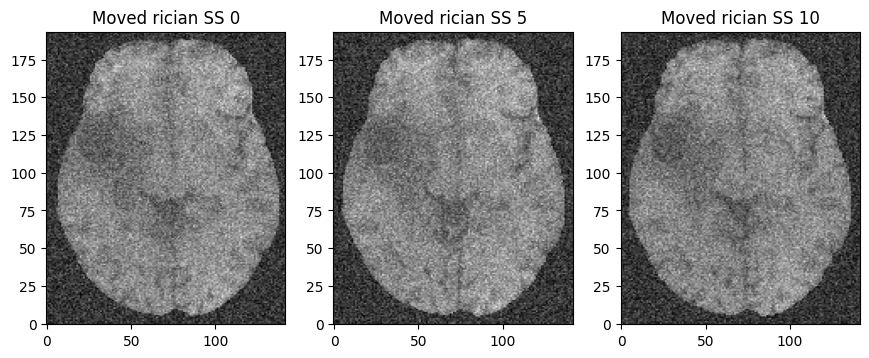

In [226]:
plot_slices(
    [snapshots[0], snapshots[5], snapshots[10]],
    titles=["Moved rician SS 0", "Moved rician SS 5", "Moved rician SS 10"]
)

In [227]:
denoised_snapshots = denoise_snapshots(snapshots, sigma=sigma)

Denoising 100 snapshots (sigma = 50).


In [228]:
norm_denoised_snapshots = []
for den_ss in denoised_snapshots:
    norm_denoised_snapshots.append(norm_img_0_255(den_ss))
norm_denoised_snapshots = np.asarray(norm_denoised_snapshots)
norm_denoised_snapshots.shape

(100, 194, 142)

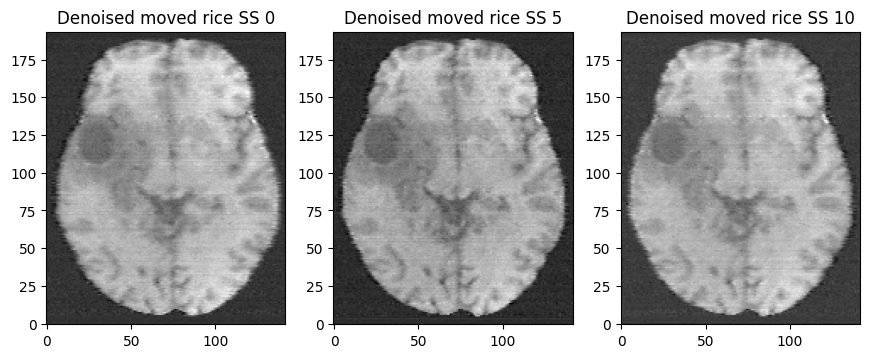

In [229]:
plot_slices(
    [denoised_snapshots[0], denoised_snapshots[5], denoised_snapshots[10]],
    titles=["Denoised moved rice SS 0", "Denoised moved rice SS 5", "Denoised moved rice SS 10"]
)

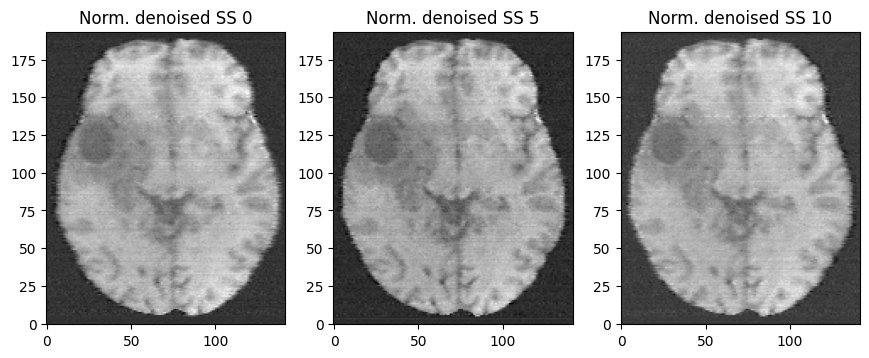

In [230]:
plot_slices([norm_denoised_snapshots[0], norm_denoised_snapshots[5], norm_denoised_snapshots[10]],
            titles=["Norm. denoised SS 0", "Norm. denoised SS 5", "Norm. denoised SS 10"])

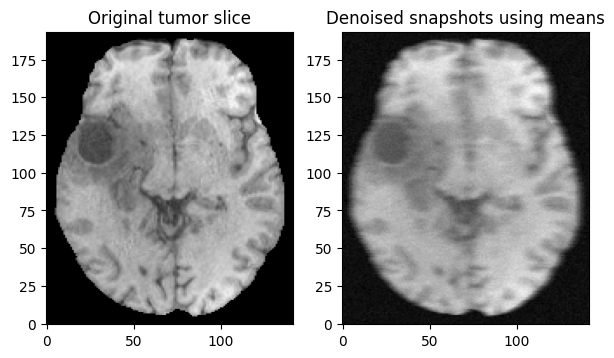

In [231]:
plot_slices(
    [pad_tumor_slice, np.mean(snapshots, axis=0)],
    titles=["Original tumor slice", "Denoised snapshots using means"]
)

In [237]:
mppca_snr_0 = compute_snr(ref_img=pad_tumor_slice, test_img=denoised_snapshots[0])
mppca_norm_snr_0 = compute_snr(ref_img=pad_tumor_slice, test_img=norm_denoised_snapshots[0])
means_snr = compute_snr(ref_img=pad_tumor_slice, test_img=np.mean(snapshots, axis=0))

print(f"SNR for denoised snapshot id=0: {mppca_snr_0}")
print(f"SNR for normalized denoised snapshot id=0: {mppca_norm_snr_0}")
print(f"SNR for denoised img using means: {means_snr}")

SNR for denoised snapshot id=0: 1.2600778870942377
SNR for normalized denoised snapshot id=0: 11.560256074140343
SNR for denoised img using means: 1.3142423639143623


In [238]:
mppca_psnr_0 = compute_psnr(ref_img=pad_tumor_slice, test_img=denoised_snapshots[0])
mppca_norm_psnr_0 = compute_psnr(ref_img=pad_tumor_slice, test_img=norm_denoised_snapshots[0])
means_psnr = compute_psnr(ref_img=pad_tumor_slice, test_img=np.mean(snapshots, axis=0))

print(f"Peak SNR for denoised snapshot id=0: {mppca_psnr_0}")
print(f"Peak SNR for normalized denoised snapshot id=0: {mppca_norm_psnr_0}")
print(f"Peak SNR for denoised img using means: {means_psnr}")

Peak SNR for denoised snapshot id=0: 6.89801462772424
Peak SNR for normalized denoised snapshot id=0: 17.19819281477034
Peak SNR for denoised img using means: 6.952179104544363


## 6.0 Adding Rician noise + displacement + missing values (not effective)

In [59]:
sigma = 50

dropout_tumor_slice = pixel_dropout(pad_tumor_slice, dropout_prob=0.05, seed=1)

dropout_snapshots = generate_rician_noisy_moved_imgs(
    original_img=dropout_tumor_slice,
    n_snapshots=100,
    rice_b=10,
    sigma=sigma,
    seed=1
)

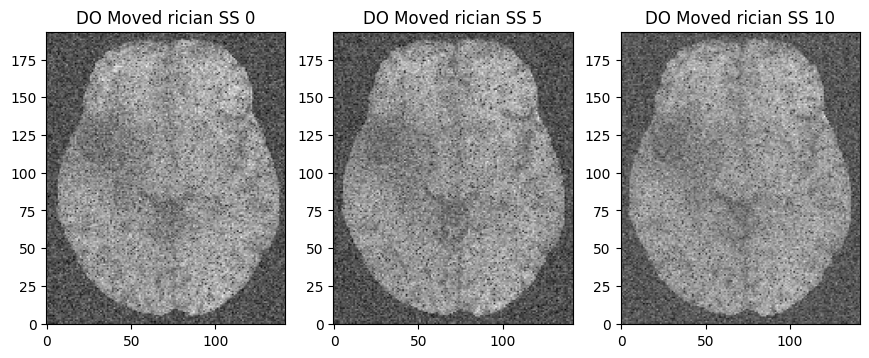

In [60]:
plot_slices(
    [dropout_snapshots[0], dropout_snapshots[5], dropout_snapshots[10]],
    titles=["DO Moved rician SS 0", "DO Moved rician SS 5", "DO Moved rician SS 10"]
)

In [61]:
denoised_snapshots = denoise_snapshots(dropout_snapshots, sigma=sigma)

Denoising 100 snapshots (sigma = 50).


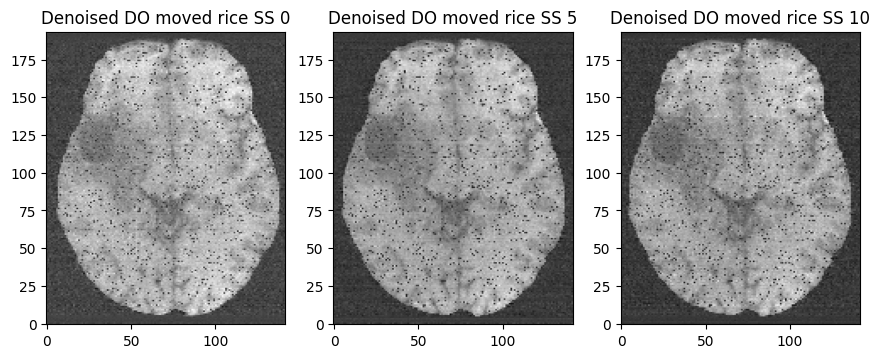

In [62]:
plot_slices(
    [denoised_snapshots[0], denoised_snapshots[5], denoised_snapshots[10]],
    titles=["Denoised DO moved rice SS 0", "Denoised DO moved rice SS 5", "Denoised DO moved rice SS 10"]
)

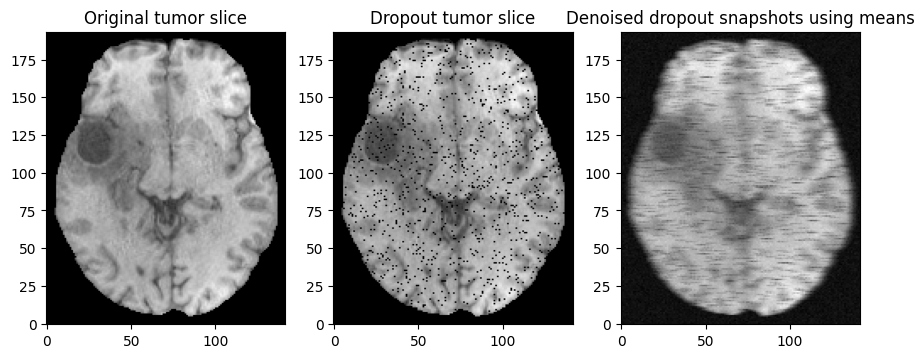

In [63]:
plot_slices(
    [pad_tumor_slice, dropout_tumor_slice, np.mean(dropout_snapshots, axis=0)],
    titles=["Original tumor slice", "Dropout tumor slice", "Denoised dropout snapshots using means"]
)

## 2. Archived: testing article results

- https://arxiv.org/pdf/1004.1356.pdf
- https://www.sciencedirect.com/science/article/abs/pii/S1053811916303949?via%3Dihub

In [12]:
X = snapshots[:,100,:]
(M, N) = X.shape

# M := number of measurements
# N := number of pixels
M, N

(100, 132)

In [13]:
Sigma = (1/N) * np.matmul(X, X.T)

In [14]:
# this could be computed with MP object
lambda_ratio = M/N
lambda_max = sigma**2 * (1 + np.sqrt(lambda_ratio))**2

print(f"Ratio (M/N): {lambda_ratio}")
print(f"Lambda max: {lambda_max}")

Ratio (M/N): 0.7575757575757576
Lambda max: 8745.88079283184


In [15]:
U, S, Vh = np.linalg.svd((1/np.sqrt(N)) * X, full_matrices=False)

print(f"Matrix shape: {X.shape}")
print(f"U shape: {U.shape}")
print(f"S shape: {S.shape}")
print(f"Vh shape: {Vh.shape}")

Matrix shape: (100, 132)
U shape: (100, 100)
S shape: (100,)
Vh shape: (100, 132)


In [16]:
recover_X = np.sqrt(N) * np.dot(U * S, Vh)
np.allclose(X, recover_X)

True

In [17]:
eigvals = S**2
eigvals.shape

(100,)

In [18]:
denoised_eigvals = np.where(eigvals <= lambda_max, 0, eigvals)
denoised_eigvals.shape

(100,)

In [19]:
denoised_eigvals[denoised_eigvals != 0.0]

array([2088803.56510293])

In [20]:
denoised_S = np.sqrt(denoised_eigvals)
denoised_S.shape

(100,)

In [21]:
denoised_S[denoised_S != 0.0]

array([1445.26937458])

In [22]:
# faster solution to get denoised_S:
test_denoised_S = np.where(S <= np.sqrt(lambda_max), 0, S)
test_denoised_S[test_denoised_S != 0.0]

array([1445.26937458])

In [23]:
denoised_X = np.sqrt(N) * np.dot(U * denoised_S, Vh)

denoised_X.shape

(100, 132)

In [24]:
def denoise_row(X):
    # M := number of measurements
    # N := number of pixels
    (M, N) = X.shape

    lambda_ratio = M/N
    lambda_max = sigma**2 * (1 + np.sqrt(lambda_ratio))**2

    U, S, Vh = np.linalg.svd((1/np.sqrt(N)) * X, full_matrices=False)

    ### Theoretical solution
    # eigvals = S**2
    # denoised_eigvals = np.where(eigvals <= lambda_max, 0, eigvals)
    # denoised_S = np.sqrt(denoised_eigvals)
    ### Faster solution
    denoised_S = np.where(S <= np.sqrt(lambda_max), 0, S)

    denoised_X = np.sqrt(N) * np.dot(U * denoised_S, Vh)

    # return np.mean(denoised_X, axis=0)   # cheating
    return denoised_X[0]


def denoise_img(snapshots, sigma):
    n_snapshots, img_height, img_width = snapshots.shape
    print(f"{n_snapshots=}")
    print(f"{img_height=}")
    print(f"{img_width=}")

    denoised_img = []
    for i in range(img_height):
        rows = snapshots[:,i,:]
        denoised_row = denoise_row(X=rows)
        denoised_img.append(denoised_row)

    d = np.asarray(denoised_img)
    print(d.shape)
    
    plot_slices([np.asarray(denoised_img)]) 

    

n_snapshots=100
img_height=184
img_width=132
(184, 132)


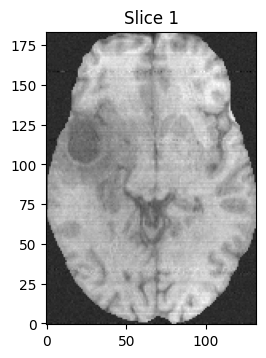

In [25]:
denoise_img(snapshots=snapshots, sigma=sigma)

### Using Marchenko-Pastur law explicitly

In [165]:
sigma = 50
snapshots = generate_noisy_imgs(tumor_slice, n_snapshots=100, sigma=sigma, seed=1)

In [166]:
X = snapshots[:,100,:]
(M, N) = X.shape

# M := number of measurements
# N := number of pixels
M, N

(100, 132)

In [167]:
U, S, Vh = np.linalg.svd((1/np.sqrt(N)) * X, full_matrices=False)

print(f"Matrix shape: {X.shape}")
print(f"U shape: {U.shape}")
print(f"S shape: {S.shape}")
print(f"Vh shape: {Vh.shape}")

Matrix shape: (100, 132)
U shape: (100, 100)
S shape: (100,)
Vh shape: (100, 132)


In [168]:
Sigma = (1/N) * np.matmul(X, X.T)

In [169]:
np.allclose(Sigma, np.dot(U * S**2, U.T))

True

In [170]:
wre = WishartEnsemble(beta=1, p=M, n=N, tridiagonal_form=False, sigma=sigma)

In [171]:
wre.matrix = Sigma

In [172]:
eigvals = wre.eigvals()

In [173]:
np.allclose(sorted(eigvals), sorted(S**2))

True

In [174]:
sorted(eigvals)[::-1][:10]

[2088803.56510293,
 8437.318508728118,
 8168.4220751715275,
 7499.34618056153,
 7391.94466996842,
 7270.727805464568,
 6788.752694468242,
 6754.679016821669,
 6657.985446754043,
 6441.243594588454]

In [175]:
sorted(S**2)[::-1][:10]

[2088803.5651029292,
 8437.318508728127,
 8168.422075171593,
 7499.346180561511,
 7391.944669968437,
 7270.727805464585,
 6788.752694468256,
 6754.6790168216685,
 6657.985446754052,
 6441.243594588463]

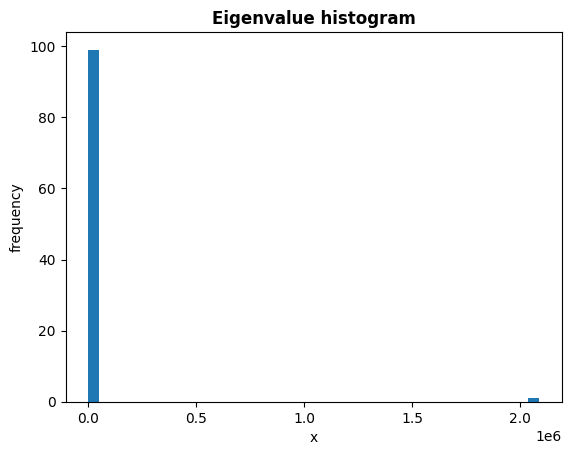

In [176]:
interval = (0.01, eigvals.max())
wre.plot_eigval_hist(bins=40, interval=interval, density=False, normalize=False)

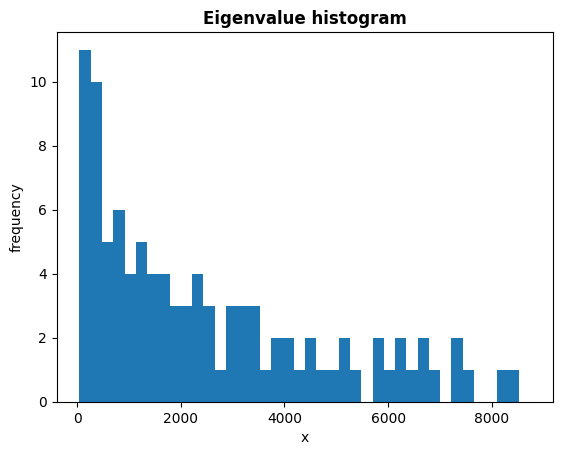

In [177]:
noise_interval = (wre.lambda_minus, wre.lambda_plus)
wre.plot_eigval_hist(bins=40, interval=noise_interval, density=False, normalize=False)

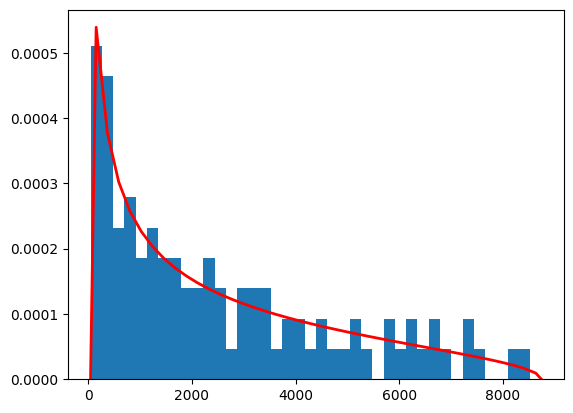

In [178]:
observed, bin_edges = wre.eigval_hist(
    bins=40, interval=noise_interval, density=True, normalize=False
)  # pylint: disable=protected-access
centers = np.asarray(get_bins_centers_and_contour(bin_edges))

mp_law = MarchenkoPasturDistribution(ratio=wre.ratio, sigma=sigma)
height = mp_law.pdf(centers)

width = bin_edges[1]-bin_edges[0]
plt.bar(bin_edges[:-1], observed, width=width, align='edge')

plt.plot(centers, height, color='red', linewidth=2)
plt.show()